Stock Data Pull

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 508 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


# Stock Tickers and Names List Creation and Percent change calculation


In [ ]:
import pandas as pd


pd.set_option('expand_frame_repr', False)
pd.set_option("display.max_rows", None, "display.max_columns", None)

# There are 4 tables on the Wikipedia page
# we want the last table

payload=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')
first_table  = payload[0]
second_table = payload[1]
third_table  = payload[2]
fourth_table = payload[3]
fifth_table = payload[4]

df = fifth_table


tickerSymbols = df['Symbol'].tolist()
tickerSymbolsFull = df['Company'].tolist()
tickerSymbols.remove('CEG')
tickerSymbols.remove('ABNB')

tickerSymbolsFull.remove('Constellation Energy')
tickerSymbolsFull.remove('Airbnb')
ticketSymbolsFull = tickerSymbolsFull
tickerSymbols = tickerSymbols

In [ ]:
tickerSymbols

In [ ]:
tickerSymbols[:10]

['ATVI', 'ADBE', 'ADP', 'ALGN', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN']

In [ ]:
import yfinance as yf

#list of the percent changes
stockPercentageChanges=[]


for tickerSymbol in tickerSymbols:  
  #get data on this ticker
  tickerData = yf.Ticker(tickerSymbol)
  tickerDf = tickerData.history(period='1mo', start='2021-06-01', end='2021-07-01')
  stockPercentageChanges.append(((tickerDf.iloc[0]['Close']-tickerDf.iloc[1]['Close'])/tickerDf.iloc[0]['Close'])*100)

#get the historical prices for this ticker

# data
stockPercentageChanges


# Tweet Scraping for stocks pulled above during given time period


In [ ]:
!pip install snscrape

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import re


all_tweets = []

for ticker in tickerSymbolsFull:
  tweets_list = []

  # Using TwitterSearchScraper to scrape data and append tweets to list
  for i,tweet in enumerate(sntwitter.TwitterSearchScraper(ticker + ' since:2021-06-01 until:2021-07-01 lang:en -is:retweet -has:links').get_items()):
      if i>200:
          break
      tweets_list.append(re.sub(r'https\S+', '', tweet.content))
  all_tweets.append(tweets_list) 


print(all_tweets)

[["@NickisRagin @RyryJones @_United_Fan @BellularGaming Huge props for doing it but someone that worships Activision blizzards choices to this degree will only come back with all that is old and useless...\n\nBut I'll add one that is in shadowlands and somehow was missed in the time gating sweep.\n\nThe Wild Hunt.", "I'll keep the monthly charts coming for the last day of the month!\n\nActivision Blizzard $ATVI is one of my favorite long-term holdings. I don't plan on selling anytime soon and will start slowly adding $100 leaps. ", '@ScarletSprites That’s honestly pretty fucking disgusting of …. Whatever Blizzard/EA/Activision are calling themselves these days 🤦🏻\u200d♂️', "@toomanysnipers @timescar226 @Diablo All they're trying to say is Blizzard invented the Soon™ meme. We need Blizzard of old to work on this, not Activision-Blizzard of today.", '@EllisWi56328520 @eanesjosh11 @bstategames Oh you mean like WoW, that whenever they have an expansion release the game is unplayable for a 

In [ ]:
print(all_tweets[0])

#Pre-processing, Neural Network Model


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
tokens = [[nlp(text_data).text.split(" ") for text_data in text_list] for text_list in all_tweets]

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv

with open("/content/drive/My Drive/CS505/tweets.csv", "w") as f:
  writer = csv.writer(f)
  for ind, company_set in enumerate(tokens):
    for tweet in company_set:
      print(ind)
      writer.writerow([str(ind)] +  [tweet] + [stockPercentageChanges[ind]])

In [ ]:
#Alternative data_load from csv to save time:
import csv
tokens, labels = [], []

with open("/content/drive/My Drive/CS505/tweets.csv", "r") as f:
  reader = csv.reader(f)
  for row in reader:
    tokens.append(row[1])
    labels.append(row[-1])

In [ ]:
import string
tokens = [[test_str.translate(str.maketrans('', '', string.punctuation)) for test_str in x.split(", ")] for x in tokens]

In [ ]:
labels = [float(x) for x in labels]

In [ ]:
flat_tokens = []
for i in tokens:
  for j in i[:200]:
    flat_tokens.append(j)

In [ ]:
from gensim.models import Word2Vec
wv_model = Word2Vec(sentences=flat_tokens,size=300, batch_words=32)

In [ ]:
vectors = []
new_labels = []
import numpy as np
for ind, company in enumerate(tokens):
  for tweet in company[:200]:
    averaged_vector = np.zeros(300)
    for word in tweet:
      try:
        averaged_vector += wv_model.wv[word]
      except KeyError:
        continue
    if len(tweet) == 0:
      continue
    averaged_vector /= len(tweet)
    if labels[ind] > 0:
      new_labels.append(1)
    else:
      new_labels.append(-1)
    vectors.append(averaged_vector)

vectors = np.asarray(vectors)
new_labels = np.asarray(new_labels)

In [ ]:
type(new_labels[0])

numpy.float64

# Logistic Regression Model


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(vectors, new_labels)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Input(300,))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1))

model.compile(optimizer="adam",loss="mean_squared_error")

In [ ]:
model.fit(vectors, labels, epochs=50, validation_split=0.2)

Epoch 1/50
403/403 [==============================] - 5s 10ms/step - loss: 2.7477 - val_loss: 2.3661
Epoch 2/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7304 - val_loss: 2.3587
Epoch 3/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7274 - val_loss: 2.3614
Epoch 4/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7185 - val_loss: 2.3631
Epoch 5/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7178 - val_loss: 2.3541
Epoch 6/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7128 - val_loss: 2.3750
Epoch 7/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7061 - val_loss: 2.3726
Epoch 8/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7062 - val_loss: 2.3645
Epoch 9/50
403/403 [==============================] - 4s 9ms/step - loss: 2.7035 - val_loss: 2.3616
Epoch 10/50
403/403 [==============================] - 3s 9ms/step - loss: 2.6994 - val_loss: 2.387

In [ ]:
trunc_vec = [x[:200] for x in vectors]

In [ ]:
import math

def calculate_RMSE(model, vectors, labels):
  y_pred = model.predict(vectors)

  total_loss = 0
  for ind, i in enumerate(y_pred):
    total_loss += (i - labels[ind]) ** 2
  
  total_loss = math.sqrt(total_loss)

  return total_loss

In [ ]:
clf.score(vectors, new_labels)

0.6157744922872347

# RMSE Calculation for logistic regression and neural network


In [ ]:
calculate_RMSE(clf, vectors, new_labels)

1218.620941884719

In [ ]:
print(nn_RMSE)

203.61348954575678


Bag of Words and Word to Vec

# Sentiment analysis with probability using Flair

In [ ]:
pip install flair

In [ ]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-12-08 22:52:13,484 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpz5ii50o1


100%|██████████| 265512723/265512723 [00:17<00:00, 15158540.03B/s]

2022-12-08 22:52:31,432 copying /tmp/tmpz5ii50o1 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-12-08 22:52:32,328 removing temp file /tmp/tmpz5ii50o1
2022-12-08 22:52:32,402 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tweetsProbabilities = []
tweetsSentiment = []


for stock in all_tweets:
  for tweet in stock:
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    tempProb=[]
    tempSentiment=[]
    tempProb.append(sentence.labels[0].score)
    tempSentiment.append(sentence.labels[0].value)
  [tweetsProbabilities.append(tempProb)]
  [tweetsSentiment.append(tempSentiment)]


In [ ]:
tweetsSentiment

In [ ]:
import numpy as np
tweetsProbabilitiesArray=np.asarray(tweetsProbabilities).reshape(10,10)
tweetsProbabilitiesArray

array([[0.99977583, 0.55780315, 0.99856418, 0.94881713, 0.83770931,
        0.90805447, 0.99970812, 0.99700528, 0.99974626, 0.99960381],
       [0.99995589, 0.99145508, 0.99999499, 0.98559546, 0.99082398,
        0.69241971, 0.60823506, 0.93970948, 0.83016431, 0.75324005],
       [0.988015  , 0.96779835, 0.99786264, 0.99914014, 0.99978524,
        0.97882873, 0.73849916, 0.9977228 , 0.52621859, 0.93536597],
       [0.99667561, 0.99985051, 0.79132682, 0.98280084, 0.99922681,
        0.99919921, 0.93689823, 0.98283398, 0.96606958, 0.99688894],
       [0.9799248 , 0.99984789, 0.99830377, 0.95015073, 0.80382651,
        0.9933995 , 0.57047826, 0.99999487, 0.92819309, 0.97367001],
       [0.55601019, 0.7885136 , 0.98926908, 0.99994397, 0.99961984,
        0.99952161, 0.99974555, 0.87595451, 0.87833786, 0.79738921],
       [0.96516991, 0.96516991, 0.97694188, 0.88626677, 0.99979109,
        0.73793548, 0.73166466, 0.99954468, 0.99458569, 0.95737886],
       [0.99989784, 0.9974196 , 0.9999755

In [ ]:
import numpy as np
tweetSentimentArray=np.asarray(tweetsSentiment).reshape(10,10)
tweetSentimentArray

array([['NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE',
        'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE'],
       ['POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE',
        'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE'],
       ['NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE',
        'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE'],
       ['POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE',
        'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE'],
       ['POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE',
        'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE'],
       ['NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE',
        'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE'],
       ['POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE',
        'POSITIVE', 'POSITIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE'],
       ['NEGATIVE', 'NEGATIVE', 'NEGATIVE

In [ ]:
import statistics
averages = []
medians=[]
for i in range(len(tickerSymbols)):
  averagedArray=[] 
  medianArray=[]
  for j, sentiment in enumerate(tweetsSentiment[i]):
      if tweetsProbabilities[i][j]>0 and sentiment == 'NEGATIVE':
        tweetsProbabilities[i][j]=tweetsProbabilities[i][j]*-1
      averagedArray.append(np.mean(tweetsProbabilities[i][j]))
      medianArray.append((tweetsProbabilities[i][j]))
  avg = np.mean(averagedArray)
  med = statistics.median(medianArray)
  averages.append(avg)
  medians.append(med)

print(averages)
print(medians)
del averages[55]

[-0.9997758269309998, 0.5578031539916992, 0.9985641837120056, 0.9488171339035034, -0.8377093076705933, -0.9080544710159302, 0.9997081160545349, -0.99700528383255, -0.9997462630271912, -0.999603807926178, 0.9999558925628662, 0.991455078125, -0.9999949932098389, -0.9855954647064209, 0.9908239841461182, -0.692419707775116, 0.6082350611686707, 0.939709484577179, -0.8301643133163452, -0.7532400488853455, -0.9880149960517883, 0.9677983522415161, 0.9978626370429993, -0.9991401433944702, -0.9997852444648743, 0.9788287281990051, 0.7384991645812988, 0.9977228045463562, 0.526218593120575, -0.9353659749031067, 0.9966756105422974, -0.9998505115509033, 0.7913268208503723, 0.9828008413314819, -0.9992268085479736, 0.9991992115974426, 0.9368982315063477, 0.982833981513977, 0.9660695791244507, 0.9968889355659485, 0.9799247980117798, -0.9998478889465332, 0.9983037710189819, 0.950150728225708, 0.8038265109062195, 0.9933995008468628, 0.5704782605171204, -0.9999948740005493, -0.9281930923461914, 0.973670005

# Linear Regression Model

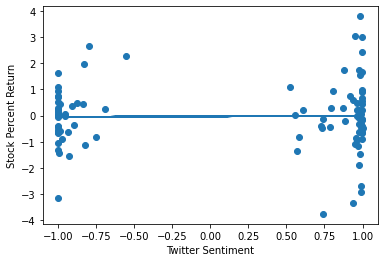

In [ ]:
import matplotlib.pyplot as plt
del stockPercentageChanges[55]
plt.scatter(averages, stockPercentageChanges)
plt.xlabel('Twitter Sentiment')
plt.ylabel('Stock Percent Return')
m,b =np.polyfit(averages, stockPercentageChanges, 1)

vals = [m*x for x in averages]
plt.plot(averages, vals+b)



# Linear MSRE Calculation

In [ ]:
import math

def calculateYExpected(x):
  return (m*x)+b

meanSqaureError = 0
squareDifferences = []
for i,average in enumerate(averages):
  dif = stockPercentageChanges[i]-calculateYExpected(average)
  squareDifferences.append(dif**2)
print(math.sqrt(sum(squareDifferences)/len(averages) ) )

1.559321870447021
